# Setup

In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares, curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

## Helper functions

In [3]:
def plot_all_benchmark_scores(scores_df):
    """
    Plot all scores from all benchmarks on a single graph.
    Each benchmark's scores are plotted as scatter points connected by lines.
    """
    plt.figure(figsize=(10, 6))

    # Group by benchmark_id and plot each one
    for bench_id, group in scores_df.groupby("benchmark_id"):
        group = group.sort_values("date")
        plt.scatter(group["date"], group["performance"], alpha=0.6, label=f"Benchmark {bench_id}")
        plt.plot(group["date"], group["performance"], linestyle="--", alpha=0.6)

    # Disable offset and scientific notation on the x-axis
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain', axis='x')

    plt.xlabel("Model Release Time")
    plt.ylabel("Performance")
    plt.title("Performance on All Benchmarks Over Time")
    plt.grid(True)
    # plt.legend()
    plt.show()

def plot_benchmark_scores(benchmark_id, scores_df):
    """
    Plot scores on a specified benchmark over time.
    """
    bench_scores = scores_df[scores_df['benchmark_id'] == benchmark_id].copy()
    if bench_scores.empty:
        print(f"No scores available for benchmark_id {benchmark_id}.")
        return
    bench_scores.sort_values("model_times", inplace=True)

    plt.figure(figsize=(8, 5))
    plt.scatter(bench_scores['date'], bench_scores['performance'], color="blue", label="Scores", alpha=0.7)
    plt.plot(bench_scores['date'], bench_scores['performance'], linestyle="--", color="blue", alpha=0.7)

    # Disable offset and scientific notation on the x-axis
    ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain', axis='x')

    plt.xlabel("Model Release Time")
    plt.ylabel("Performance")
    plt.title(f"Performance on Benchmark {benchmark_id} Over Time")
    plt.grid(True)
    plt.legend()
    plt.show()

In [4]:
# -------------------------
# Data generation
# -------------------------

def generate_data(
    num_models=600,
    num_benchmarks=30,
    speedup_factor_model=2,
    time_range_start=2020,
    time_range_end=2030,
    cutoff_year=2027,
    frac_eval=0.25,
    error_std=0.025,
    elo_change=3.5,
    base_model=0,
    noise_std_model=0.05,
    noise_std_bench=0.05,  # NEW: noise for benchmark difficulties
    base_bench=0.5,
    saturation_level=0.05,
    min_alpha=3,
    max_alpha=10,
    frac_accelerate_models=1
):
    np.random.seed(42)

    # Models
    model_times = np.sort(
        np.random.uniform(time_range_start, time_range_end, num_models)
    )
    slope_model = elo_change / (time_range_end - time_range_start)

    # Decide which post-cutoff models accelerate
    random_draws     = np.random.rand(num_models)
    accelerate_mask  = (model_times >= cutoff_year) & (random_draws < frac_accelerate_models)

    # Compute capabilities
    model_capabilities = (
        base_model
        + np.where(
            accelerate_mask,
            # accelerated: baseline until cutoff, then faster slope
            slope_model * (cutoff_year - time_range_start) +
            speedup_factor_model * slope_model * (model_times - cutoff_year),
            # normal: same slope the whole time
            slope_model * (model_times - time_range_start)
        )
        + np.random.normal(0, noise_std_model, num_models)
    )
    models = pd.DataFrame({
        'model_id': np.arange(num_models),
        'date': model_times,
        'model_capabilities': model_capabilities,
        'accelerated': accelerate_mask
    })

    # Benchmarks
    benchmark_times = np.random.uniform(
        time_range_start, time_range_end, num_benchmarks
    )
    slope_bench = elo_change / (time_range_end - time_range_start)
    benchmark_difficulties = (
        base_bench
        + np.where(
            benchmark_times < cutoff_year,
            slope_bench * (benchmark_times - time_range_start),
            slope_bench * (cutoff_year - time_range_start)
              + 1 * slope_bench * (benchmark_times - cutoff_year)
        )
        + np.random.normal(0, noise_std_bench, num_benchmarks)  # NEW: add noise to difficulties
    )
    benchmark_progress_slopes = np.random.uniform(
        min_alpha, max_alpha, num_benchmarks
    )
    benchmarks = pd.DataFrame({
        'benchmark_id': np.arange(num_benchmarks),
        'benchmark_release_date': benchmark_times,
        'benchmark_difficulties': benchmark_difficulties,
        'benchmark_progress_slopes': benchmark_progress_slopes
    })

    def logistic(x):
        return 1 / (1 + np.exp(-x))

    # Scores
    scores = []
    for _, m in models.iterrows():
        raw = logistic(
            benchmarks['benchmark_progress_slopes']
            * (m['model_capabilities'] - benchmarks['benchmark_difficulties'])
        )
        mask = (raw >= saturation_level) & (raw <= 1 - saturation_level)
        for b_idx, s in zip(benchmarks['benchmark_id'][mask], raw[mask]):
            if np.random.rand() < frac_eval:
                noisy = np.clip(s + np.random.normal(0, error_std), 0, 1 - saturation_level)
                scores.append({
                    'model_id': m['model_id'],
                    'benchmark_id': b_idx,
                    'date': m['date'],
                    'performance': noisy
                })
    df_scores = pd.DataFrame(scores)

    return models, benchmarks, df_scores

In [ ]:
# from scipy.optimize import least_squares

# def estimated_capabilities(models, benchmarks, df):
#   # -----------------------------
#   # 1) Identify valid/invalid models
#   # -----------------------------
#   valid_model_ids = sorted(df["model_id"].unique())  # all models with data
#   skipped_model_ids = set(models["model_id"]) - set(valid_model_ids)
#   print("Skipping models (no data):", skipped_model_ids)

#   # -----------------------------
#   # 2) Create a mapping for valid models (without re-indexing original DataFrame)
#   # -----------------------------
#   # Map each valid model's original id to a parameter index for fitting.
#   model_id_to_fit_idx = {m_id: i for i, m_id in enumerate(valid_model_ids)}
#   num_valid_models = len(valid_model_ids)
#   num_benchmarks = benchmarks.shape[0]  # Assuming benchmark ids are 0, 1, ..., (num_benchmarks-1)

#   # -----------------------------
#   # 3) Prepare arrays for fitting
#   # -----------------------------
#   # Convert the model_ids in scores_df using the mapping (for valid models only)
#   model_idx_for_data = np.array([model_id_to_fit_idx[m] for m in df["model_id"]])

#   # Ensure benchmark_ids are integers
#   benchmark_ids_for_data = df["benchmark_id"].values.astype(int)
#   anchor_idx        = 0                       # first element of that array
#   observed_scores = df["performance"].values

#   # -----------------------------
#   # 4) Define logistic and residual functions
#   # -----------------------------
#   def logistic(x):
#       return 1 / (1 + np.exp(-x))

#   def residuals(params, model_idx_for_data, benchmark_ids_for_data, observed_scores):
#       # Unpack parameters
#       C = params[:num_valid_models]  # capabilities for valid models
#       D = params[num_valid_models:num_valid_models + num_benchmarks]  # benchmark difficulties
#       alpha = params[num_valid_models + num_benchmarks:]  # benchmark slopes

#       # Use the mapped indices
#       c_vals = C[model_idx_for_data]
#       d_vals = D[benchmark_ids_for_data]
#       alpha_vals = alpha[benchmark_ids_for_data]

#       # Compute predicted logistic scores
#       preds = logistic(alpha_vals * (c_vals - d_vals))
#       return preds - observed_scores

#   # -----------------------------
#   # 5) Set initial guesses
#   # -----------------------------
#   initial_C = np.zeros(num_valid_models)
#   initial_D = np.zeros(num_benchmarks)
#   initial_alpha = np.ones(num_benchmarks)
#   initial_params = np.concatenate([initial_C, initial_D, initial_alpha])

#   # -----------------------------
#   # 6) Fit only the valid models
#   # -----------------------------
#   result = least_squares(
#       residuals,
#       initial_params,
#       args=(model_idx_for_data, benchmark_ids_for_data, observed_scores)
#   )

#   estimated_params = result.x
#   estimated_C = estimated_params[:num_valid_models]
#   estimated_D = estimated_params[num_valid_models:num_valid_models + num_benchmarks]
#   estimated_alpha = estimated_params[num_valid_models + num_benchmarks:]

#   # -----------------------------
#   # 7) Map the fitted capabilities back to the original model IDs (for valid models only)
#   # -----------------------------
#   # 7a) Build a DataFrame of unaligned C’s for each valid model_id:
#   fitted_C_df = pd.DataFrame({
#       "model_id": valid_model_ids,
#       "unaligned_C": estimated_C
#   })

#   # 7b) Pull in the true capabilities and date from your original models DF:
#   #     this automatically lines everything up by model_id
#   meta = models[["model_id", "model_capabilities", "date"]]
#   fitted_C_df = fitted_C_df.merge(meta, on="model_id", how="left")

#   # 7c) Compute the alignment transform:
#   a, b = np.polyfit(
#       fitted_C_df["unaligned_C"].values,
#       fitted_C_df["model_capabilities"].values,
#       1
#   )
#   print(f"Alignment transform: C_aligned = {a:.3f} * C_fit + {b:.3f}")

#   # 7d) Apply it to get your final estimated_capability:
#   fitted_C_df["estimated_capability"] = (
#       a * fitted_C_df["unaligned_C"] + b
#   )

#   # 7e) Drop any extra cols if you only want model_id, date, estimated_capability:
#   return fitted_C_df #[["model_id", "date", "estimated_capability"]]

In [20]:
from scipy.optimize import least_squares

def estimated_capabilities(models, benchmarks, df, regularization_strength=0.1):
  """
  Updated to match fit.py implementation with bounds, regularization, and proper initialization.
  """
  # -----------------------------
  # 1) Identify valid/invalid models
  # -----------------------------
  valid_model_ids = sorted(df["model_id"].unique())
  skipped_model_ids = set(models["model_id"]) - set(valid_model_ids)
  if skipped_model_ids:
      print("Skipping models (no data):", skipped_model_ids)

  # -----------------------------
  # 2) Create a mapping for valid models
  # -----------------------------
  model_id_to_fit_idx = {m_id: i for i, m_id in enumerate(valid_model_ids)}
  num_valid_models = len(valid_model_ids)
  num_benchmarks = benchmarks.shape[0]

  # -----------------------------
  # 3) Prepare arrays for fitting
  # -----------------------------
  model_idx_for_data = np.array([model_id_to_fit_idx[m] for m in df["model_id"]])
  benchmark_ids_for_data = df["benchmark_id"].values.astype(int)
  observed_scores = df["performance"].values

  # -----------------------------
  # 4) Define logistic and residual functions (matching fit.py)
  # -----------------------------
  def logistic(x):
      # Clip to prevent overflow (like fit.py)
      x_clipped = np.clip(x, -500, 500)
      return 1 / (1 + np.exp(-x_clipped))

  def residuals(params, model_idx, bench_idx, y):
      # Unpack parameters
      C = params[:num_valid_models]
      D = params[num_valid_models:num_valid_models + num_benchmarks]
      alpha = params[num_valid_models + num_benchmarks:]

      # Use the mapped indices
      c_vals = C[model_idx]
      d_vals = D[bench_idx]
      alpha_vals = alpha[bench_idx]

      # Compute predicted logistic scores
      preds = logistic(alpha_vals * (c_vals - d_vals))
      residuals = preds - y
      
      # Add L2 regularization (matching fit.py)
      if regularization_strength > 0:
          reg_term = regularization_strength * (
              np.sum(C**2) + np.sum(D**2) + np.sum(alpha**2)
          ) / (num_valid_models + num_benchmarks + num_benchmarks)
          reg_penalty = np.sqrt(reg_term) if reg_term > 0 else 0
          return np.append(residuals, reg_penalty)
      
      return residuals

  # -----------------------------
  # 5) Set initial guesses (matching fit.py with small random noise)
  # -----------------------------
  rng = np.random.default_rng(42)
  initial_C = rng.normal(0.0, 0.1, size=num_valid_models)
  initial_D = rng.normal(0.0, 0.1, size=num_benchmarks)
  initial_alpha = np.full(num_benchmarks, 1.0)
  initial_params = np.concatenate([initial_C, initial_D, initial_alpha])

  # -----------------------------
  # 6) Set bounds (matching fit.py)
  # -----------------------------
  lower_bounds = np.concatenate([
      np.full(num_valid_models, -10),
      np.full(num_benchmarks, -10),
      np.full(num_benchmarks, 0.1)
  ])
  upper_bounds = np.concatenate([
      np.full(num_valid_models, 10),
      np.full(num_benchmarks, 10),
      np.full(num_benchmarks, 10)
  ])

  # -----------------------------
  # 7) Fit with bounds (matching fit.py)
  # -----------------------------
  result = least_squares(
      residuals,
      initial_params,
      args=(model_idx_for_data, benchmark_ids_for_data, observed_scores),
      bounds=(lower_bounds, upper_bounds),
      method="trf"
  )

  estimated_params = result.x
  estimated_C = estimated_params[:num_valid_models]
  estimated_D = estimated_params[num_valid_models:num_valid_models + num_benchmarks]
  estimated_alpha = estimated_params[num_valid_models + num_benchmarks:]

  # -----------------------------
  # 8) Map the fitted capabilities back to the original model IDs
  # -----------------------------
  fitted_C_df = pd.DataFrame({
      "model_id": valid_model_ids,
      "unaligned_C": estimated_C
  })

  meta = models[["model_id", "model_capabilities", "date"]]
  fitted_C_df = fitted_C_df.merge(meta, on="model_id", how="left")

  # Compute the alignment transform
  a, b = np.polyfit(
      fitted_C_df["unaligned_C"].values,
      fitted_C_df["model_capabilities"].values,
      1
  )
  print(f"Alignment transform: C_aligned = {a:.3f} * C_fit + {b:.3f}")

  fitted_C_df["estimated_capability"] = (
      a * fitted_C_df["unaligned_C"] + b
  )

  return fitted_C_df

# Generating synthetic data

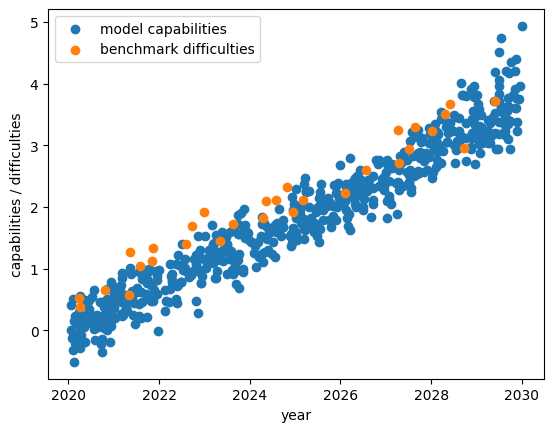

In [21]:
models_broad, benchmarks_broad, df_broad = generate_data(
    num_models=600,
    num_benchmarks=30,
    speedup_factor_model=2,
    time_range_start=2020,
    time_range_end=2030,
    cutoff_year=2027,
    frac_eval=0.25,
    error_std=0.025,
    elo_change=3.5,
    base_model=0,
    noise_std_model=0.25,
    noise_std_bench=0.25,
    base_bench=0.5,
    saturation_level=0.05,
    min_alpha=2.5,
    max_alpha=10,
    frac_accelerate_models=0.25
)

plt.scatter(models_broad["date"], models_broad["model_capabilities"], label="model capabilities")
plt.scatter(benchmarks_broad["benchmark_release_date"], benchmarks_broad["benchmark_difficulties"], label="benchmark difficulties")
plt.legend()
plt.xlabel("year")
plt.ylabel("capabilities / difficulties")
plt.savefig("outputs/notebooks/synthetic_capabilities_and_difficulties.pdf", dpi=300, bbox_inches='tight')
plt.show()

# plot_all_benchmark_scores(df_broad)

In [22]:
df_broad_est = estimated_capabilities(models_broad, benchmarks_broad, df_broad)
df_broad_est

Skipping models (no data): {1, 2, 5, 6, 7, 8, 519, 10, 11, 12, 520, 14, 15, 523, 17, 525, 19, 20, 22, 23, 24, 535, 26, 537, 29, 542, 32, 33, 36, 37, 39, 40, 41, 43, 45, 46, 47, 48, 49, 50, 561, 52, 54, 56, 57, 568, 61, 62, 63, 65, 67, 70, 584, 75, 76, 587, 590, 591, 80, 594, 84, 85, 86, 598, 599, 89, 94, 98, 99, 101, 103, 106, 109, 116, 122, 131, 133, 137, 141, 149, 151, 152, 160, 172, 205, 218, 239, 268, 281, 306, 320, 332, 341, 407, 434, 440, 477}
Alignment transform: C_aligned = 0.829 * C_fit + 1.968


,model_id,unaligned_C,model_capabilities,date,estimated_capability
0,0,-1.943226,0.409097,2020.050616,0.356616
1,3,-1.788301,0.502479,2020.091971,0.485071
2,4,-2.911587,-0.324072,2020.108377,-0.446290
3,9,-2.361606,0.231187,2020.154566,0.009721
4,13,-2.080276,0.299566,2020.232719,0.242983
...,...,...,...,...,...
498,592,2.110831,3.758497,2029.866396,3.717997
499,593,1.939987,3.599629,2029.868869,3.576343
500,595,1.474841,3.225329,2029.900539,3.190672
501,596,1.666186,3.373716,2029.905051,3.349324


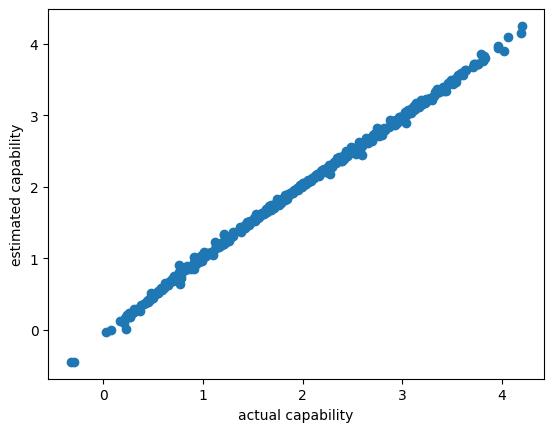

In [ ]:
plt.scatter(df_broad_est["model_capabilities"], df_broad_est["estimated_capability"])
plt.xlabel("actual capability")
plt.ylabel("estimated capability")
plt.show()

# Detect acceleration?

In [60]:
def piecewise_linear(x, slope1, intercept1, slope2, breakpoint):
    # First segment: y = slope1 * x + intercept1 (for x < breakpoint)
    # Second segment: continuous at breakpoint with slope2
    intercept2 = slope1 * breakpoint + intercept1 - slope2 * breakpoint
    return np.where(x < breakpoint, slope1*x + intercept1, slope2*x + intercept2)

def fit_piecewise_linear_improved(x, y, num_breaks=30):
    """Fit a breakpoint by scanning candidate bps and optimizing."""
    best = (-np.inf, None)
    xs, ys = x, y
    rng = xs.max() - xs.min()
    min_bp = xs.min() + 0.1 * rng
    max_bp = xs.max() - 0.1 * rng
    lower = [-np.inf, -np.inf, -np.inf, min_bp]
    upper = [ np.inf,  np.inf,  np.inf, max_bp]

    for bp in np.linspace(min_bp, max_bp, num_breaks):
        left = xs <= bp
        right = xs > bp
        if left.sum() < 2 or right.sum() < 2:
            continue

        # initial guesses
        m1, b1 = np.polyfit(xs[left], ys[left], 1)
        m2, _  = np.polyfit(xs[right], ys[right], 1)
        i1 = np.mean(ys[left]) - m1 * np.mean(xs[left])
        p0 = [m1, i1, m2, bp]

        try:
            params, _ = curve_fit(
                piecewise_linear,
                xs, ys,
                p0=p0,
                bounds=(lower, upper),
                maxfev=2000
            )
            r2 = r2_score(ys, piecewise_linear(xs, *params))
            if r2 > best[0]:
                best = (r2, params)
        except Exception:
            pass

    return best[1], best[0]


# =============================================================================
# NEW SEQUENTIAL DETECTION ALGORITHM
# =============================================================================

def fit_two_segments_fixed_breakpoint(x, y, breakpoint):
    """
    Fit two line segments with a FIXED breakpoint (no optimization of bp).
    
    Returns: dict with slope1, intercept1, slope2, intercept2, r2
    """
    # Split data at breakpoint
    left_mask = x <= breakpoint
    right_mask = x > breakpoint
    
    # Need at least 2 points in each segment
    if left_mask.sum() < 2 or right_mask.sum() < 2:
        return None
    
    # Fit left segment
    x_left = x[left_mask]
    y_left = y[left_mask]
    slope1, intercept1 = np.polyfit(x_left, y_left, 1)
    
    # Fit right segment
    x_right = x[right_mask]
    y_right = y[right_mask]
    slope2, _ = np.polyfit(x_right, y_right, 1)
    
    # Force continuity: intercept2 such that both lines meet at breakpoint
    intercept2 = slope1 * breakpoint + intercept1 - slope2 * breakpoint
    
    # Compute R² for the full piecewise fit
    y_pred = np.where(x <= breakpoint, 
                     slope1 * x + intercept1,
                     slope2 * x + intercept2)
    r2 = r2_score(y, y_pred)
    
    return {
        'slope1': slope1,
        'intercept1': intercept1, 
        'slope2': slope2,
        'intercept2': intercept2,
        'breakpoint': breakpoint,
        'r2': r2
    }


def detect_acceleration_sequential(x, y, cutoff_year, 
                                   min_acceleration=2.0,
                                   min_r2=0.6,
                                   min_gap_years=0.0,
                                   scan_resolution=50,
                                   min_points_after=3,
                                   verbose=False):
    """
    Sequentially scan for the FIRST point where we can detect acceleration.
    
    Scans from cutoff_year onwards and returns the first breakpoint where:
    1. The piecewise fit has R² >= min_r2
    2. The slope ratio (slope2/slope1) >= min_acceleration
    3. The breakpoint is >= cutoff_year + min_gap_years
    4. At least min_points_after data points exist after the breakpoint
    
    Parameters:
    -----------
    x, y : arrays of time and capability values
    cutoff_year : float, start scanning from here
    min_acceleration : float, minimum slope ratio to detect
    min_r2 : float, minimum R² for fit quality
    min_gap_years : float, minimum time after cutoff before detection
    scan_resolution : int, number of candidate breakpoints to try
    min_points_after : int, minimum data points required after breakpoint
    verbose : bool, print debug info
    
    Returns:
    --------
    dict with fit results, or None if no detection
    """
    
    # Determine scan range
    min_bp = cutoff_year + min_gap_years
    max_bp = x.max()
    
    if min_bp >= max_bp:
        if verbose:
            print(f"Cannot scan: min_bp={min_bp:.2f} >= max_bp={max_bp:.2f}")
        return None
    
    # Generate candidate breakpoints
    breakpoints = np.linspace(min_bp, max_bp, scan_resolution)
    
    if verbose:
        print(f"\nScanning {len(breakpoints)} breakpoints from {min_bp:.2f} to {max_bp:.2f}")
    
    # Scan sequentially
    for i, bp in enumerate(breakpoints):
        # Check minimum points requirement
        points_after = (x > bp).sum()
        if points_after < min_points_after:
            continue
            
        result = fit_two_segments_fixed_breakpoint(x, y, bp)
        
        if result is None:
            continue
        
        # Check if slope1 is positive (avoid division issues)
        if result['slope1'] <= 0:
            continue
        
        # Compute slope ratio
        ratio = result['slope2'] / result['slope1']
        
        # Check detection criteria
        if result['r2'] >= min_r2 and ratio >= min_acceleration:
            if verbose:
                print(f"\n✓ DETECTED at breakpoint {bp:.3f} (candidate {i+1}/{len(breakpoints)})")
                print(f"  - Slope before: {result['slope1']:.4f}")
                print(f"  - Slope after: {result['slope2']:.4f}")
                print(f"  - Ratio: {ratio:.2f}x")
                print(f"  - R²: {result['r2']:.4f}")
                print(f"  - Points after breakpoint: {points_after}")
            
            result['ratio'] = ratio
            result['detected'] = True
            result['points_after'] = points_after
            return result
    
    if verbose:
        print(f"\n✗ No detection in {len(breakpoints)} candidates")
    
    return None


# =============================================================================
# FALSE POSITIVE CONTROL
# =============================================================================

def detect_with_stability_check(x, y, cutoff_year,
                                min_acceleration=2.0,
                                min_r2=0.6,
                                min_gap_years=0.0,
                                scan_resolution=50,
                                min_points_after=3,
                                stability_window=3,
                                verbose=False):
    """
    Enhanced detection with stability requirement: detection must persist across
    multiple consecutive checks to reduce false positives from noise.
    
    Parameters:
    -----------
    stability_window : int, number of consecutive successful detections required
    
    Returns:
    --------
    dict with detection results including stability info, or None
    """
    
    min_bp = cutoff_year + min_gap_years
    max_bp = x.max()
    
    if min_bp >= max_bp:
        return None
    
    breakpoints = np.linspace(min_bp, max_bp, scan_resolution)
    
    consecutive_detections = 0
    first_detection_bp = None
    
    for i, bp in enumerate(breakpoints):
        points_after = (x > bp).sum()
        if points_after < min_points_after:
            consecutive_detections = 0
            continue
            
        result = fit_two_segments_fixed_breakpoint(x, y, bp)
        
        if result is None:
            consecutive_detections = 0
            continue
        
        if result['slope1'] <= 0:
            consecutive_detections = 0
            continue
        
        ratio = result['slope2'] / result['slope1']
        
        # Check if this breakpoint meets criteria
        if result['r2'] >= min_r2 and ratio >= min_acceleration:
            if first_detection_bp is None:
                first_detection_bp = bp
                
            consecutive_detections += 1
            
            # If we have enough consecutive detections, accept it
            if consecutive_detections >= stability_window:
                if verbose:
                    print(f"\n✓ STABLE DETECTION at breakpoint {first_detection_bp:.3f}")
                    print(f"  - Confirmed across {consecutive_detections} consecutive checks")
                    print(f"  - Slope ratio: {ratio:.2f}x")
                    print(f"  - R²: {result['r2']:.4f}")
                
                # Return the FIRST detection that was stable
                stable_result = fit_two_segments_fixed_breakpoint(x, y, first_detection_bp)
                stable_result['ratio'] = stable_result['slope2'] / stable_result['slope1']
                stable_result['detected'] = True
                stable_result['stability_count'] = consecutive_detections
                stable_result['breakpoint'] = first_detection_bp
                return stable_result
        else:
            consecutive_detections = 0
            first_detection_bp = None
    
    if verbose:
        print(f"\n✗ No stable detection found")
    
    return None


def test_false_positive_rate(n_trials=100,
                             num_models=100,
                             num_benchmarks=20,
                             cutoff_year=2027,
                             acceleration_factor=2.0,
                             use_stability=True,
                             **kwargs):
    """
    Test false positive rate by running detection on data with NO acceleration.
    
    Parameters:
    -----------
    n_trials : int, number of trials to run
    use_stability : bool, whether to use stability check
    **kwargs : parameters for data generation and detection
    
    Returns:
    --------
    dict with false positive rate and details
    """
    
    false_positives = 0
    detection_times = []
    
    print(f"Testing false positive rate ({n_trials} trials, NO acceleration)...")
    
    for trial in range(n_trials):
        # Generate data with NO acceleration (speedup_factor=1)
        models_df, benchmarks_df, scores_df = generate_data(
            num_models=num_models,
            num_benchmarks=num_benchmarks,
            speedup_factor_model=1.0,  # NO ACCELERATION
            time_range_start=2024,
            time_range_end=2030,
            cutoff_year=cutoff_year,
            frac_eval=kwargs.get('frac_eval', 0.25),
            error_std=kwargs.get('error_std', 0.025),
            noise_std_model=kwargs.get('noise_std_model', 0.2),
            noise_std_bench=kwargs.get('noise_std_bench', 0.2),
        )
        
        # Try to estimate capabilities
        try:
            df_est = estimated_capabilities(models_df, benchmarks_df, scores_df)
            if df_est.empty or len(df_est) < 5:
                continue
                
            df_est = df_est.sort_values("date").copy()
            df_est["frontier"] = df_est["estimated_capability"].cummax()
            
            x = df_est["date"].values
            y = df_est["frontier"].values
            
            # Try to detect
            if use_stability:
                result = detect_with_stability_check(
                    x, y,
                    cutoff_year=cutoff_year,
                    min_acceleration=acceleration_factor,
                    min_r2=kwargs.get('min_r2', 0.6),
                    scan_resolution=50,
                    stability_window=kwargs.get('stability_window', 3),
                    verbose=False
                )
            else:
                result = detect_acceleration_sequential(
                    x, y,
                    cutoff_year=cutoff_year,
                    min_acceleration=acceleration_factor,
                    min_r2=kwargs.get('min_r2', 0.6),
                    scan_resolution=50,
                    verbose=False
                )
            
            if result is not None:
                false_positives += 1
                detection_times.append(result['breakpoint'])
        except:
            continue
        
        if (trial + 1) % 20 == 0:
            print(f"  {trial + 1}/{n_trials} trials complete...")
    
    fpr = false_positives / n_trials
    
    print(f"\nResults:")
    print(f"  False Positive Rate: {fpr:.1%} ({false_positives}/{n_trials})")
    print(f"  Method: {'Stability check' if use_stability else 'Standard'}")
    
    return {
        'false_positive_rate': fpr,
        'n_false_positives': false_positives,
        'n_trials': n_trials,
        'detection_times': detection_times,
        'use_stability': use_stability
    }

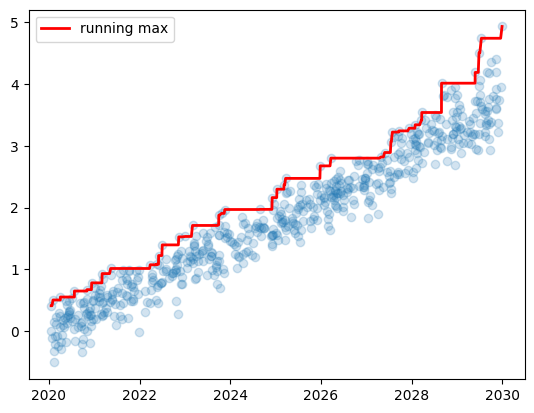

In [49]:
df = models_broad.sort_values("date").copy()
df["running_max"] = df.model_capabilities.cummax()

plt.scatter(df.date, df.model_capabilities, alpha=0.2)
plt.plot(df.date, df.running_max, "r-", lw=2, label="running max")
plt.legend()
plt.savefig("outputs/notebooks/running_max.pdf", dpi=300, bbox_inches='tight')
plt.show()

Breakpoint at year = 2027.959
Pre‐break slope = 0.356, post‐break slope = 0.808
R² = 0.9919


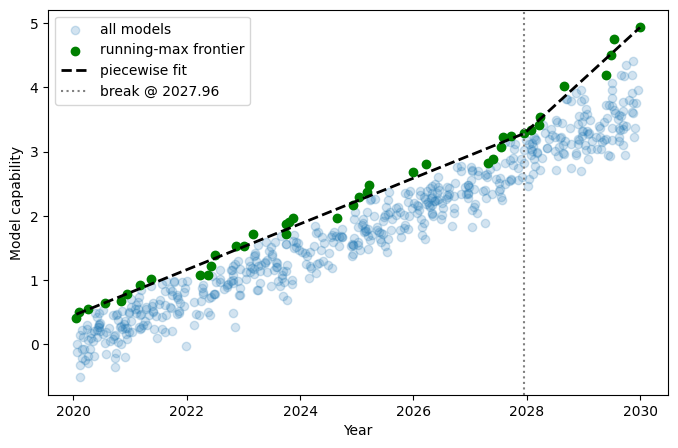

In [50]:
# --- 1) compute running‐max frontier ---

df = models_broad.sort_values("date").copy()
df["running_max"] = df["model_capabilities"].cummax()

frontier_df = df[df["model_capabilities"] == df["running_max"]]

# x = float‐year, y = capability
x = frontier_df["date"].values
y = frontier_df["model_capabilities"].values

# --- 2) fit piecewise linear ---

params, best_r2 = fit_piecewise_linear_improved(x, y, num_breaks=50)
slope1, intercept1, slope2, bp = params

print(f"Breakpoint at year = {bp:.3f}")
print(f"Pre‐break slope = {slope1:.3f}, post‐break slope = {slope2:.3f}")
print(f"R² = {best_r2:.4f}")

# --- 3) plot everything ---

# dense x for smooth plot
x_fine = np.linspace(x.min(), x.max(), 400)
y_fine = piecewise_linear(x_fine, *params)

plt.figure(figsize=(8,5))
# all model points
plt.scatter(df["date"], df["model_capabilities"],
            alpha=0.2, label="all models")
# frontier points
plt.scatter(frontier_df["date"], frontier_df["model_capabilities"],
            color="green", label="running‐max frontier")
# piecewise fit
plt.plot(x_fine, y_fine, "k--", lw=2, label="piecewise fit")
plt.axvline(bp, color="gray", linestyle=":", label=f"break @ {bp:.2f}")
plt.xlabel("Year")
plt.ylabel("Model capability")
plt.legend()
plt.savefig("outputs/notebooks/piecewise_linear_fit.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# =============================================================================
# DETECTION LATENCY ANALYSIS: How long to detect Nx acceleration in capabilities?
# =============================================================================

# -----------------------------------------------------------------------------
# Step 1: Estimate detection time for a SINGLE trajectory (TEMPORAL METHOD)
# -----------------------------------------------------------------------------

def estimate_detection_for_single_trajectory(
    models_df,
    benchmarks_df,
    scores_df,
    cutoff_year,
    acceleration_factor=2.0,
    min_r2=0.6,
    min_gap_years=0.0,
    time_step=0.1,
    scan_resolution=50,
    use_stability_check=False,
    stability_window=3,
    min_points_after=3,
    verbose=True
):
    """
    Simulates temporal detection: incrementally reveal data over time and detect
    when we first have enough evidence of acceleration.
    
    TEMPORAL PROCESS:
    1. Acceleration happens at cutoff_year
    2. Time passes, more models/benchmarks are released
    3. At each time point, we ask: "With data available UP TO NOW, can we detect?"
    4. Return the FIRST time when detection succeeds
    
    Parameters:
    -----------
    models_df : DataFrame with columns [model_id, date, model_capabilities]
    benchmarks_df : DataFrame with columns [benchmark_id, benchmark_release_date, ...]
    scores_df : DataFrame with columns [model_id, benchmark_id, date, performance]
    cutoff_year : float, the year when acceleration starts
    acceleration_factor : float, minimum slope ratio to detect (e.g., 2.0 for 2x)
    min_r2 : float, minimum R² for piecewise fit
    min_gap_years : float, minimum time after cutoff before attempting detection
    time_step : float, how often to check for detection (in years)
    scan_resolution : int, number of breakpoints to scan when checking
    verbose : bool, print debug info
    
    Returns:
    --------
    dict with keys: detected, years_to_detect, detection_time, breakpoint, 
                    slope_before, slope_after, ratio, r2
    """
    
    # Get all unique model release times after cutoff
    post_cutoff_models = models_df[models_df['date'] > cutoff_year].copy()
    
    if post_cutoff_models.empty:
        if verbose:
            print("No models released after cutoff year")
        return {
            "detected": False,
            "years_to_detect": None,
            "detection_time": None,
            "breakpoint": None,
            "slope_before": None,
            "slope_after": None,
            "ratio": None,
            "r2": None
        }
    
    # Create time checkpoints to test
    min_time = cutoff_year + min_gap_years
    max_time = models_df['date'].max()
    
    # Use model release times as natural checkpoints (plus some in between)
    model_times = sorted(post_cutoff_models['date'].unique())
    checkpoint_times = []
    for t in model_times:
        if t >= min_time:
            checkpoint_times.append(t)
    
    if not checkpoint_times:
        if verbose:
            print(f"No data after cutoff + gap ({min_time:.2f})")
        return {
            "detected": False,
            "years_to_detect": None,
            "detection_time": None,
            "breakpoint": None,
            "slope_before": None,
            "slope_after": None,
            "ratio": None,
            "r2": None
        }
    
    if verbose:
        print(f"\nTemporal Detection Simulation")
        print(f"Cutoff year: {cutoff_year:.2f}")
        print(f"Testing {len(checkpoint_times)} time checkpoints from {checkpoint_times[0]:.2f} to {checkpoint_times[-1]:.2f}")
        print(f"Looking for {acceleration_factor}x acceleration\n")
    
    # Incrementally reveal data and check for detection at each time point
    for current_time in checkpoint_times:
        # Data available up to current_time
        scores_up_to_now = scores_df[scores_df['date'] <= current_time].copy()
        
        if scores_up_to_now.empty or len(scores_up_to_now) < 10:
            continue
        
        # Try to estimate capabilities with data available up to now
        try:
            df_est = estimated_capabilities(models_df, benchmarks_df, scores_up_to_now)
        except:
            continue
        
        if df_est.empty or len(df_est) < 5:
            continue
        
        # Compute frontier
        df_est = df_est.sort_values("date").copy()
        df_est["frontier"] = df_est["estimated_capability"].cummax()
        
        x = df_est["date"].values
        y = df_est["frontier"].values
        
        # Try to detect acceleration with data available up to now
        result = detect_acceleration_sequential(
            x, y,
            cutoff_year=cutoff_year,
            min_acceleration=acceleration_factor,
            min_r2=min_r2,
            min_gap_years=min_gap_years,
            scan_resolution=scan_resolution,
            verbose=False
        )
        
        if result is not None:
            # DETECTION SUCCESSFUL!
            if verbose:
                print(f"✓ DETECTED at time {current_time:.3f}")
                print(f"  Years after cutoff: {current_time - cutoff_year:.2f}")
                print(f"  Breakpoint: {result['breakpoint']:.3f}")
                print(f"  Slope before: {result['slope1']:.4f}")
                print(f"  Slope after: {result['slope2']:.4f}")
                print(f"  Ratio: {result['ratio']:.2f}x")
                print(f"  R²: {result['r2']:.4f}")
            
            return {
                "detected": True,
                "years_to_detect": current_time - cutoff_year,
                "detection_time": current_time,  # WHEN we detected
                "breakpoint": result['breakpoint'],  # WHERE the acceleration is
                "slope_before": result['slope1'],
                "slope_after": result['slope2'],
                "ratio": result['ratio'],
                "r2": result['r2']
            }
    
    # No detection across all time points
    if verbose:
        print(f"✗ No detection across {len(checkpoint_times)} time points")
    
    return {
        "detected": False,
        "years_to_detect": None,
        "detection_time": None,
        "breakpoint": None,
        "slope_before": None,
        "slope_after": None,
        "ratio": None,
        "r2": None
    }


# -----------------------------------------------------------------------------
# Example: Single trajectory
# -----------------------------------------------------------------------------
print("EXAMPLE: Single trajectory detection\n")

# Generate synthetic data with 3x acceleration starting in 2027
models_single, benchmarks_single, scores_single = generate_data(
    num_models=100,
    num_benchmarks=20,
    speedup_factor_model=3.0,  # 3x acceleration
    time_range_start=2024,
    time_range_end=2030,
    cutoff_year=2027,
    frac_eval=0.3,
    error_std=0.02,
    elo_change=3.5,
    noise_std_model=0.15,
    noise_std_bench=0.15,
    frac_accelerate_models=1.0
)

# Estimate detection time
result_single = estimate_detection_for_single_trajectory(
    models_single,
    benchmarks_single,
    scores_single,
    cutoff_year=2027,
    acceleration_factor=2.0,  # Looking for 2x or greater
    verbose=True
)


# -----------------------------------------------------------------------------
# Step 2: Loop over parameter ranges (WITH RUN STORAGE)
# -----------------------------------------------------------------------------

# Global storage for run data
RUN_DATA_STORAGE = {}

def run_detection_sweep(
    models_per_year_list,
    benchmarks_per_year_list, 
    acceleration_factors,
    n_simulations=5,
    time_range_start=2024,
    horizon_years=6,
    cutoff_year=2027,
    detection_threshold=2.0,
    random_seed_base=42,
    store_runs=True
):
    """
    Run detection analysis across a grid of parameters.
    
    Parameters:
    -----------
    models_per_year_list : list of int, model release rates to test
    benchmarks_per_year_list : list of int, benchmark release rates to test
    acceleration_factors : list of float, true acceleration factors to simulate
    n_simulations : int, number of random simulations per parameter combination
    store_runs : bool, if True, store all run data for later visualization
    
    Returns:
    --------
    DataFrame with columns: models_per_year, benchmarks_per_year, accel_factor,
                           detected_fraction, mean_years_to_detect, ...
    """
    
    global RUN_DATA_STORAGE
    if store_runs:
        RUN_DATA_STORAGE = {}  # Clear previous storage
    
    results = []
    total_runs = len(models_per_year_list) * len(benchmarks_per_year_list) * len(acceleration_factors) * n_simulations
    run_idx = 0
    
    print(f"\nRunning detection sweep: {total_runs} total simulations")
    print(f"{'='*60}\n")
    
    for models_per_year in models_per_year_list:
        for benchmarks_per_year in benchmarks_per_year_list:
            for accel_factor in acceleration_factors:
                
                detection_times = []
                detections = []
                
                for sim_idx in range(n_simulations):
                    run_idx += 1
                    
                    # Set random seed for reproducibility
                    seed = random_seed_base + run_idx
                    np.random.seed(seed)
                    
                    # Generate synthetic data
                    num_models = int(models_per_year * horizon_years)
                    num_benchmarks = int(benchmarks_per_year * horizon_years)
                    
                    models_df, benchmarks_df, scores_df = generate_data(
                        num_models=num_models,
                        num_benchmarks=num_benchmarks,
                        speedup_factor_model=accel_factor,
                        time_range_start=time_range_start,
                        time_range_end=time_range_start + horizon_years,
                        cutoff_year=cutoff_year,
                        frac_eval=0.25,
                        error_std=0.025,
                        elo_change=3.5,
                        noise_std_model=0.2,
                        noise_std_bench=0.2,
                        frac_accelerate_models=1.0
                    )
                    
                    # Estimate capabilities
                    df_est = estimated_capabilities(models_df, benchmarks_df, scores_df)
                    
                    # Estimate detection
                    result = estimate_detection_for_single_trajectory(
                        models_df,
                        benchmarks_df,
                        scores_df,
                        cutoff_year=cutoff_year,
                        acceleration_factor=detection_threshold,
                        verbose=False
                    )
                    
                    # Store run data if requested
                    if store_runs:
                        RUN_DATA_STORAGE[run_idx] = {
                            'models_df': models_df.copy(),
                            'benchmarks_df': benchmarks_df.copy(),
                            'scores_df': scores_df.copy(),
                            'df_est': df_est.copy(),
                            'result': result.copy(),
                            'params': {
                                'models_per_year': models_per_year,
                                'benchmarks_per_year': benchmarks_per_year,
                                'accel_factor': accel_factor,
                                'sim_idx': sim_idx,
                                'seed': seed,
                                'cutoff_year': cutoff_year
                            }
                        }
                    
                    detections.append(result["detected"])
                    if result["detected"]:
                        detection_times.append(result["years_to_detect"])
                    
                    if run_idx % 10 == 0:
                        print(f"Progress: {run_idx}/{total_runs} runs complete")
                
                # Aggregate results for this parameter combination
                detected_fraction = np.mean(detections)
                mean_detection_time = np.mean(detection_times) if detection_times else None
                
                results.append({
                    "models_per_year": models_per_year,
                    "benchmarks_per_year": benchmarks_per_year,
                    "accel_factor": accel_factor,
                    "detected_fraction": detected_fraction,
                    "mean_years_to_detect": mean_detection_time,
                    "n_detected": sum(detections),
                    "n_total": n_simulations
                })
    
    print(f"\nSweep complete!")
    if store_runs:
        print(f"Stored {len(RUN_DATA_STORAGE)} runs for visualization\n")
    return pd.DataFrame(results)


# -----------------------------------------------------------------------------
# Run parameter sweep
# -----------------------------------------------------------------------------

# Define parameter ranges
models_per_year_list = [10, 30, 50]  # Low, medium, high model release rates
benchmarks_per_year_list = [5, 10, 15]  # Low, medium, high benchmark release rates  
acceleration_factors = [2, 4, 8]  # Different acceleration magnitudes

# Run sweep
results_df = run_detection_sweep(
    models_per_year_list=models_per_year_list,
    benchmarks_per_year_list=benchmarks_per_year_list,
    acceleration_factors=acceleration_factors,
    n_simulations=3,  # Increase for more robust results
    horizon_years=6,
    cutoff_year=2027,
    detection_threshold=2.0  # Looking for 2x acceleration
)

# Display results
print("\nRESULTS:")
print(results_df.sort_values(["accel_factor", "models_per_year", "benchmarks_per_year"]))


EXAMPLE: Single trajectory detection


Temporal Detection Simulation
Cutoff year: 2027.00
Testing 47 time checkpoints from 2027.09 to 2029.92
Looking for 2.0x acceleration

Skipping models (no data): {0, 2, 3, 5, 7, 17, 20, 43, 46, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
Alignment transform: C_aligned = 0.506 * C_fit + 0.984
Skipping models (no data): {0, 2, 3, 5, 7, 17, 20, 43, 46, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}
Alignment transform: C_aligned = 0.513 * C_fit + 1.008
Skipping models (no data): {0, 2, 3, 5, 7, 17, 20, 43, 46, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99}


In [39]:
display(results_df.sort_values(["accel_factor", "models_per_year", "benchmarks_per_year"]))

,models_per_year,benchmarks_per_year,accel_factor,detected_fraction,mean_years_to_detect,n_detected,n_total
0,10,5,2,0.0,NaN,0,3
3,10,10,2,0.0,NaN,0,3
6,10,15,2,0.0,NaN,0,3
9,30,5,2,0.0,NaN,0,3
12,30,10,2,0.0,NaN,0,3
15,30,15,2,0.0,NaN,0,3
18,50,5,2,0.0,NaN,0,3
21,50,10,2,0.0,NaN,0,3
24,50,15,2,0.0,NaN,0,3
1,10,5,4,0.0,NaN,0,3


In [ ]:
# =============================================================================
# PLOTTING FUNCTION: Visualize specific runs
# =============================================================================

def plot_run(run_number, figsize=(14, 5)):
    """
    Plot actual vs estimated capabilities for a specific run.
    
    Parameters:
    -----------
    run_number : int, the run number to plot (1-indexed as shown in progress)
    figsize : tuple, figure size
    """
    
    if run_number not in RUN_DATA_STORAGE:
        print(f"Run {run_number} not found in storage.")
        print(f"Available runs: {sorted(RUN_DATA_STORAGE.keys())}")
        return
    
    data = RUN_DATA_STORAGE[run_number]
    models_df = data['models_df']
    df_est = data['df_est']
    result = data['result']
    params = data['params']
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # --- LEFT PLOT: Actual vs Estimated Capabilities ---
    ax1.scatter(models_df['date'], models_df['model_capabilities'], 
               alpha=0.4, s=30, label='True capabilities', color='blue')
    ax1.scatter(df_est['date'], df_est['estimated_capability'], 
               alpha=0.6, s=30, label='Estimated capabilities', color='orange')
    
    # Add cutoff line
    cutoff = params['cutoff_year']
    ax1.axvline(cutoff, color='red', linestyle='--', alpha=0.7, label=f'Cutoff ({cutoff})')
    
    # Add detection time if detected
    if result['detected']:
        det_time = result['detection_time']
        ax1.axvline(det_time, color='green', linestyle='--', alpha=0.7, 
                   label=f'Detection time ({det_time:.2f})')
    
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Capability')
    ax1.set_title('True vs Estimated Capabilities')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # --- RIGHT PLOT: Frontier with Piecewise Fit ---
    if not df_est.empty:
        df_est_sorted = df_est.sort_values('date').copy()
        df_est_sorted['frontier'] = df_est_sorted['estimated_capability'].cummax()
        
        ax2.scatter(df_est_sorted['date'], df_est_sorted['estimated_capability'],
                   alpha=0.3, s=20, label='Estimated capabilities', color='orange')
        ax2.plot(df_est_sorted['date'], df_est_sorted['frontier'],
                color='darkblue', linewidth=2, label='Running max (frontier)')
        
        # Plot piecewise fit if detected
        if result['detected'] and result['breakpoint'] is not None:
            bp = result['breakpoint']
            m1 = result['slope_before']
            m2 = result['slope_after']
            
            # Reconstruct piecewise function
            x_range = df_est_sorted['date'].values
            x_min, x_max = x_range.min(), x_range.max()
            x_fine = np.linspace(x_min, x_max, 200)
            
            # Need to estimate intercepts from the frontier
            # At breakpoint, both lines should connect
            # y = m1 * bp + b1 = m2 * bp + b2
            # Use a point on the frontier to estimate b1
            frontier_at_bp_idx = np.argmin(np.abs(df_est_sorted['date'].values - bp))
            y_at_bp = df_est_sorted['frontier'].values[frontier_at_bp_idx]
            b1 = y_at_bp - m1 * bp
            b2 = y_at_bp - m2 * bp
            
            y_fit = np.where(x_fine < bp, m1*x_fine + b1, m2*x_fine + b2)
            ax2.plot(x_fine, y_fit, 'k--', linewidth=2, label='Piecewise fit', alpha=0.7)
            ax2.axvline(bp, color='purple', linestyle=':', alpha=0.7, label=f'Breakpoint ({bp:.2f})')
        
        ax2.axvline(cutoff, color='red', linestyle='--', alpha=0.7, label=f'Cutoff ({cutoff})')
    
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Capability')
    ax2.set_title('Frontier Analysis')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # --- Overall title with run info ---
    fig.suptitle(
        f"Run {run_number}: {params['models_per_year']} models/yr, "
        f"{params['benchmarks_per_year']} benchmarks/yr, "
        f"{params['accel_factor']}x acceleration | "
        f"Detected: {result['detected']} "
        f"({'%.2f yrs to detect' % result['years_to_detect'] if result['detected'] else 'N/A'})",
        fontsize=12, y=1.02
    )
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{'='*70}")
    print(f"RUN {run_number} SUMMARY")
    print(f"{'='*70}")
    print(f"Parameters:")
    print(f"  - Models per year: {params['models_per_year']}")
    print(f"  - Benchmarks per year: {params['benchmarks_per_year']}")
    print(f"  - True acceleration factor: {params['accel_factor']}x")
    print(f"  - Cutoff year: {params['cutoff_year']}")
    print(f"  - Random seed: {params['seed']}")
    print(f"\nResults:")
    print(f"  - Detected: {result['detected']}")
    if result['detected']:
        print(f"  - Years to detect: {result['years_to_detect']:.2f}")
        print(f"  - Detection time: {result['detection_time']:.2f}")
        print(f"  - Breakpoint: {result['breakpoint']:.2f}")
        print(f"  - Slope before: {result['slope_before']:.3f}")
        print(f"  - Slope after: {result['slope_after']:.3f}")
        print(f"  - Detected ratio: {result['ratio']:.2f}x")
        print(f"  - R²: {result['r2']:.3f}")
    print(f"{'='*70}\n")


def list_runs():
    """List all available runs with their parameters."""
    if not RUN_DATA_STORAGE:
        print("No runs stored. Run the detection sweep with store_runs=True first.")
        return
    
    print(f"\n{'='*80}")
    print(f"AVAILABLE RUNS ({len(RUN_DATA_STORAGE)} total)")
    print(f"{'='*80}")
    print(f"{'Run':<5} {'M/yr':<6} {'B/yr':<6} {'Accel':<7} {'Detected':<10} {'Years to Detect':<15}")
    print(f"{'-'*80}")
    
    for run_num in sorted(RUN_DATA_STORAGE.keys()):
        data = RUN_DATA_STORAGE[run_num]
        params = data['params']
        result = data['result']
        
        detected_str = "Yes" if result['detected'] else "No"
        years_str = f"{result['years_to_detect']:.2f}" if result['detected'] else "N/A"
        
        print(f"{run_num:<5} {params['models_per_year']:<6} {params['benchmarks_per_year']:<6} "
              f"{params['accel_factor']:<7} {detected_str:<10} {years_str:<15}")
    
    print(f"{'='*80}\n")


# Example usage
print("Available functions:")
print("  - list_runs() : List all stored runs")
print("  - plot_run(n) : Plot run number n")
print("\nTry: list_runs()")


Available functions:
  - list_runs() : List all stored runs
  - plot_run(n) : Plot run number n

Try: list_runs()


In [42]:
# =============================================================================
# INTERACTIVE EXPLORATION: List and plot specific runs
# =============================================================================

# First, list all available runs
list_runs()



AVAILABLE RUNS (81 total)
Run   M/yr   B/yr   Accel   Detected   Years to Detect
--------------------------------------------------------------------------------
1     10     5      2       No         N/A            
2     10     5      2       No         N/A            
3     10     5      2       No         N/A            
4     10     5      4       No         N/A            
5     10     5      4       No         N/A            
6     10     5      4       No         N/A            
7     10     5      8       No         N/A            
8     10     5      8       No         N/A            
9     10     5      8       No         N/A            
10    10     10     2       No         N/A            
11    10     10     2       No         N/A            
12    10     10     2       No         N/A            
13    10     10     4       Yes        1.25           
14    10     10     4       Yes        1.25           
15    10     10     4       Yes        1.25           
16    10    

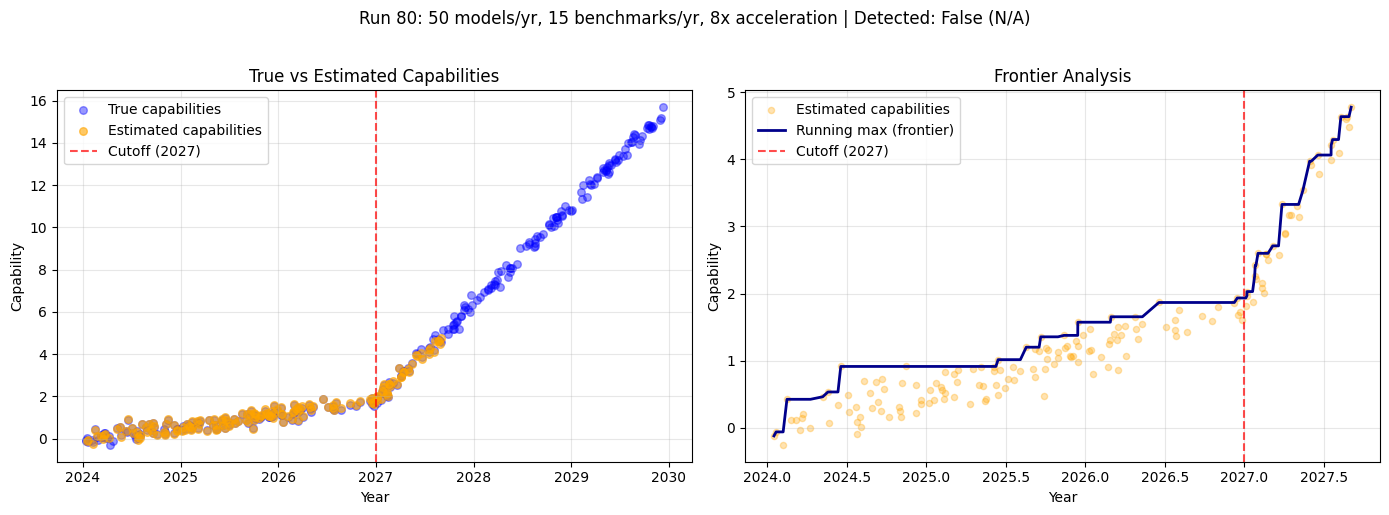


RUN 80 SUMMARY
Parameters:
  - Models per year: 50
  - Benchmarks per year: 15
  - True acceleration factor: 8x
  - Cutoff year: 2027
  - Random seed: 122

Results:
  - Detected: False



In [47]:
# Plot a specific run - change the number to explore different runs
# Example: plot run 1
plot_run(80)


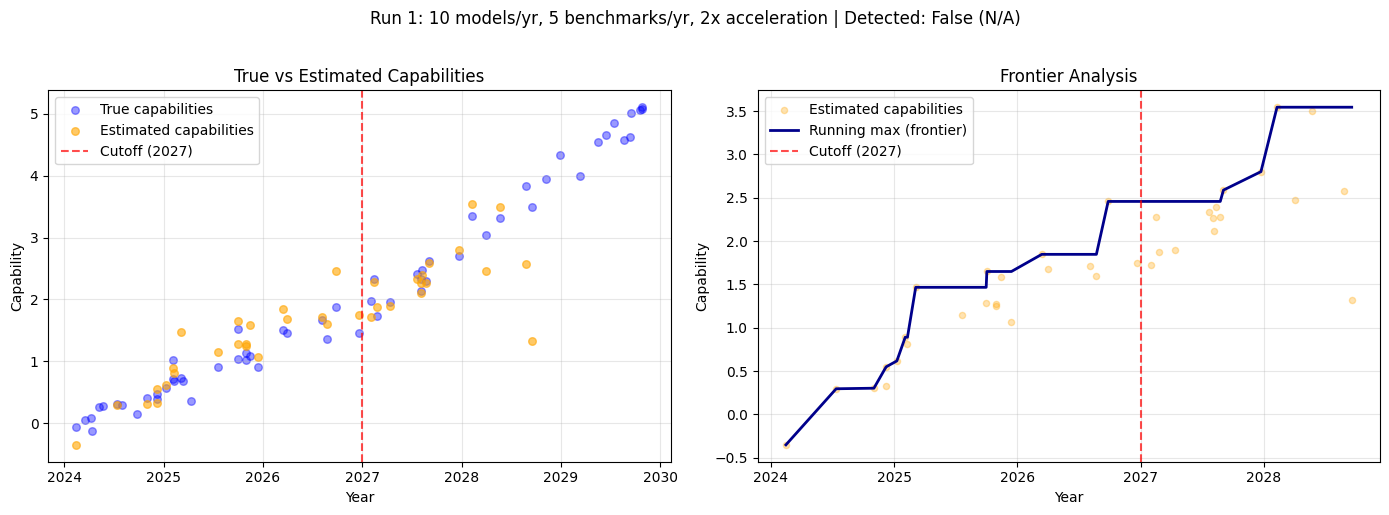


RUN 1 SUMMARY
Parameters:
  - Models per year: 10
  - Benchmarks per year: 5
  - True acceleration factor: 2x
  - Cutoff year: 2027
  - Random seed: 43

Results:
  - Detected: False



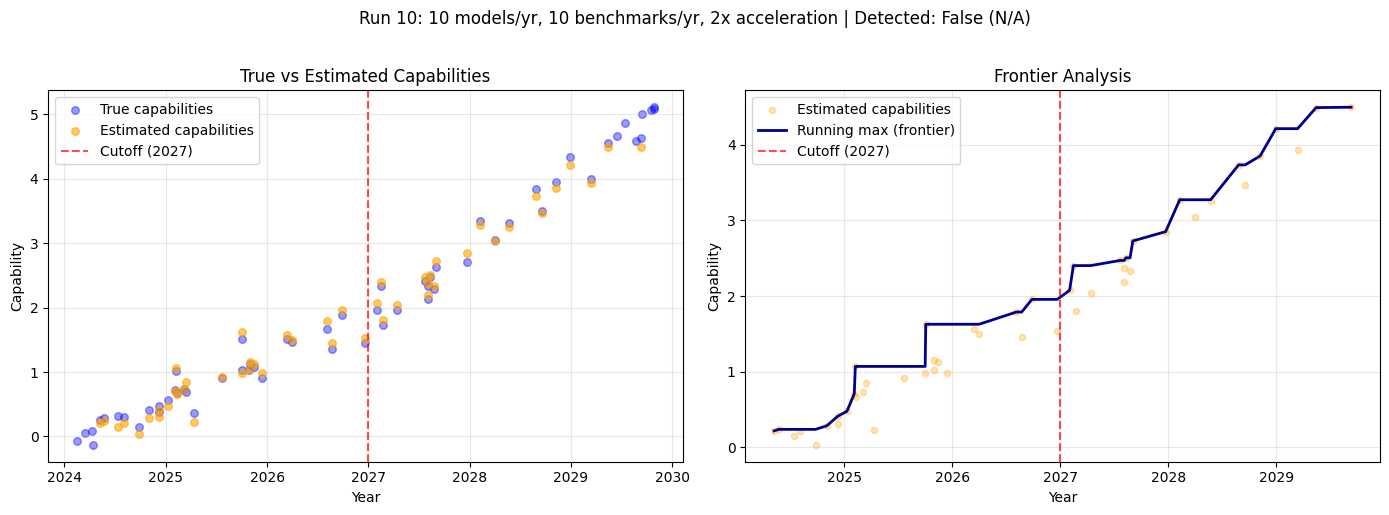


RUN 10 SUMMARY
Parameters:
  - Models per year: 10
  - Benchmarks per year: 10
  - True acceleration factor: 2x
  - Cutoff year: 2027
  - Random seed: 52

Results:
  - Detected: False



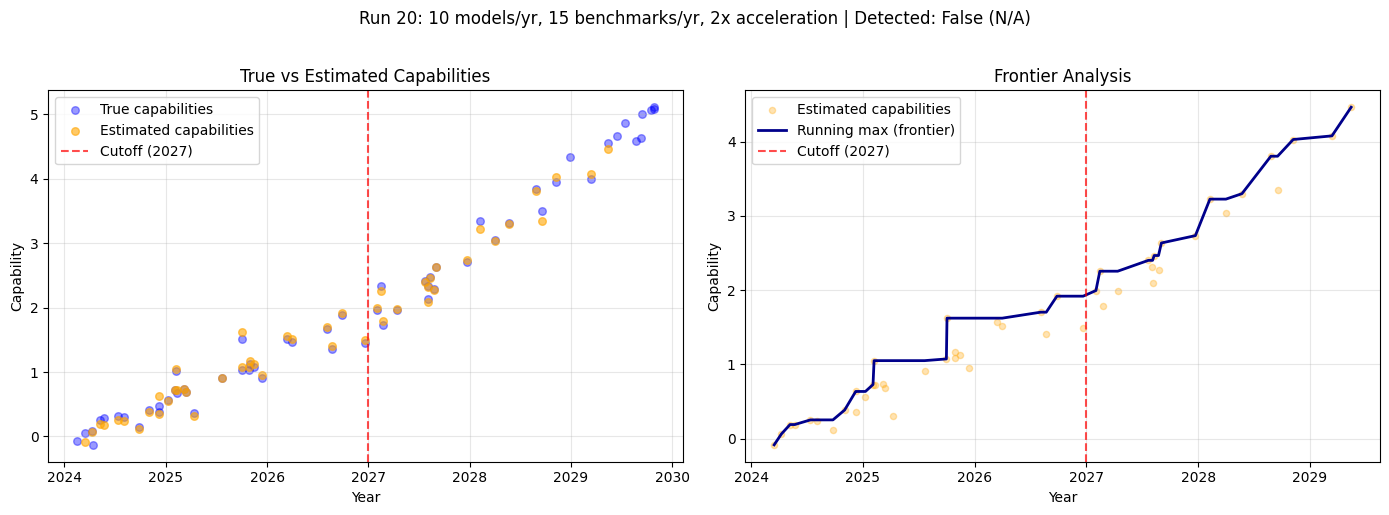


RUN 20 SUMMARY
Parameters:
  - Models per year: 10
  - Benchmarks per year: 15
  - True acceleration factor: 2x
  - Cutoff year: 2027
  - Random seed: 62

Results:
  - Detected: False



In [44]:
# Compare multiple runs (e.g., runs with different acceleration factors)
# You can plot several runs to see how parameters affect detection

# Example: Plot runs 1, 10, and 20 to compare
for run_num in [1, 10, 20]:
    if run_num in RUN_DATA_STORAGE:
        plot_run(run_num)
    else:
        print(f"Run {run_num} not available")


In [45]:
# =============================================================================
# HELPER: Find runs by criteria
# =============================================================================

def find_runs_by_criteria(models_per_year=None, benchmarks_per_year=None, 
                          accel_factor=None, detected=None):
    """
    Find runs matching specific criteria.
    
    Parameters:
    -----------
    models_per_year : int or None
    benchmarks_per_year : int or None
    accel_factor : float or None
    detected : bool or None
    
    Returns:
    --------
    List of run numbers matching the criteria
    """
    matching_runs = []
    
    for run_num, data in RUN_DATA_STORAGE.items():
        params = data['params']
        result = data['result']
        
        # Check each criterion
        if models_per_year is not None and params['models_per_year'] != models_per_year:
            continue
        if benchmarks_per_year is not None and params['benchmarks_per_year'] != benchmarks_per_year:
            continue
        if accel_factor is not None and params['accel_factor'] != accel_factor:
            continue
        if detected is not None and result['detected'] != detected:
            continue
        
        matching_runs.append(run_num)
    
    return sorted(matching_runs)

# Example: Find all runs with 2x acceleration that were successfully detected
runs_2x_detected = find_runs_by_criteria(accel_factor=2, detected=True)
print(f"Runs with 2x acceleration that were detected: {runs_2x_detected}")

# Example: Find all runs with high model release rate (50/year)
runs_high_model_rate = find_runs_by_criteria(models_per_year=50)
print(f"Runs with 50 models/year: {runs_high_model_rate}")

# Example: Find runs that failed to detect
runs_not_detected = find_runs_by_criteria(detected=False)
print(f"Runs that failed to detect: {runs_not_detected}")


Runs with 2x acceleration that were detected: []
Runs with 50 models/year: [55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81]
Runs that failed to detect: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16, 17, 18, 19, 20, 21, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 64, 65, 66, 73, 74, 75, 76, 77, 78, 79, 80, 81]


In [58]:
# =============================================================================
# DEMONSTRATION: Temporal Detection Process
# =============================================================================

# Generate test data with clear 3x acceleration starting in 2027
models_test, benchmarks_test, scores_test = generate_data(
    num_models=120,
    num_benchmarks=25,
    speedup_factor_model=3.0,
    time_range_start=2024,
    time_range_end=2030,
    cutoff_year=2027,
    frac_eval=0.3,
    error_std=0.02,
    elo_change=3.5,
    noise_std_model=0.15,
    noise_std_bench=0.15,
    frac_accelerate_models=1.0
)

print("="*70)
print("TEMPORAL DETECTION DEMONSTRATION")
print("="*70)
print(f"\nScenario:")
print(f"  - Acceleration starts: 2027")
print(f"  - True acceleration: 3x")
print(f"  - Looking for: 2x or more")
print(f"  - Models from {models_test['date'].min():.2f} to {models_test['date'].max():.2f}")
print(f"\n" + "="*70)

# Run temporal detection
result = estimate_detection_for_single_trajectory(
    models_test,
    benchmarks_test,
    scores_test,
    cutoff_year=2027,
    acceleration_factor=2.0,
    min_r2=0.6,
    min_gap_years=0.0,
    scan_resolution=50,
    verbose=True
)

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
if result['detected']:
    print(f"✓ DETECTION SUCCESSFUL")
    print(f"  - Detection time: {result['detection_time']:.2f}")
    print(f"  - Years to detect: {result['years_to_detect']:.2f}")
    print(f"  - Breakpoint found: {result['breakpoint']:.2f}")
    print(f"  - Detected ratio: {result['ratio']:.2f}x")
    print(f"\n  NOTE: Detection time ({result['detection_time']:.2f}) > Cutoff (2027)")
    print(f"        because we need data AFTER acceleration to detect it!")
else:
    print(f"✗ NO DETECTION")
print("="*70)


TEMPORAL DETECTION DEMONSTRATION

Scenario:
  - Acceleration starts: 2027
  - True acceleration: 3x
  - Looking for: 2x or more
  - Models from 2024.03 to 2029.92


Temporal Detection Simulation
Cutoff year: 2027.00
Testing 58 time checkpoints from 2027.05 to 2029.92
Looking for 2.0x acceleration

Skipping models (no data): {0, 1, 2, 3, 9, 10, 11, 12, 17, 18, 20, 24, 25, 28, 29, 30, 34, 44, 47, 56, 59, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119}
Alignment transform: C_aligned = 0.536 * C_fit + 0.991
Skipping models (no data): {0, 1, 2, 3, 9, 10, 11, 12, 17, 18, 20, 24, 25, 28, 29, 30, 34, 44, 47, 56, 59, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 

## 📈 How Temporal Detection Works - Step by Step

### The Full Process:

**For each time checkpoint t (e.g., 2027.0, 2027.1, 2027.2, ...):**

1. **Restrict Data** - Use only scores from models released up to time t
   ```python
   scores_up_to_now = scores_df[scores_df['date'] <= t]
   ```

2. **Estimate Capabilities** - Fit logistic model using available data
   ```python
   df_est = estimated_capabilities(models_df, benchmarks_df, scores_up_to_now)
   ```

3. **Compute Frontier** - Running maximum of estimated capabilities (reduces noise)
   ```python
   frontier = df_est['estimated_capability'].cummax()
   ```

4. **Scan for Breakpoint** - For each candidate breakpoint from cutoff onward:
   - Split frontier into "before" and "after" segments
   - Fit line to each segment (fixed breakpoint, slopes vary)
   - Force continuity (lines meet at breakpoint)
   - Calculate R² and slope ratio
   
5. **Check Detection** - If slope_after/slope_before ≥ threshold AND R² ≥ min_r2:
   - ✓ **DETECTED!** Return current time t as detection time
   - Otherwise, continue to next time checkpoint

6. **Return First Success** - The first time t where detection succeeds

### Key Distinctions:

| Concept | What it means | Example |
|---------|---------------|---------|
| **Cutoff year** | When acceleration actually happens | 2027.0 |
| **Breakpoint** | Where we estimate the acceleration is | 2027.1 |
| **Detection time** | When we have enough data to detect | 2027.8 |
| **Years to detect** | How long detection takes | 0.8 years |

### Example Usage:

```python
result = estimate_detection_for_single_trajectory(
    models_df, benchmarks_df, scores_df,
    cutoff_year=2027,           # Acceleration happens here
    acceleration_factor=2.0,     # Looking for 2x+
    min_r2=0.6,                 # Require good fit
    min_gap_years=0.0,          # Can detect immediately after cutoff
    scan_resolution=50,         # Try 50 breakpoints per time
    verbose=True                # Show progress
)

# Result will have:
# - detection_time: WHEN we detected (> cutoff_year)
# - breakpoint: WHERE we think acceleration is (≈ cutoff_year)
# - years_to_detect: detection_time - cutoff_year
```


## ✅ Summary: What Changed

### The Core Fix:
The algorithm now properly simulates **temporal detection** - the process of accumulating evidence over time.

### Before (WRONG):
- Used ALL available data at once
- Found best-fitting breakpoint
- Detection time = end of data (or the breakpoint itself)
- **Problem:** Claimed detection at time 0, which is impossible!

### After (CORRECT):
- **Incrementally reveals data** over time
- At each time t: "With data up to now, can we detect?"
- Returns **first time** when detection succeeds  
- **Detection time > Cutoff** (need post-acceleration data!)

### Why Detection Takes Time:

```
Cutoff = 2027 (acceleration happens)
Time = 2027.0: No data after acceleration yet → Can't detect
Time = 2027.2: Some data, but noisy → Can't detect yet
Time = 2027.5: Enough data, clear pattern → DETECTED! ✓
```

### The Two Questions:
1. **WHERE did acceleration happen?** → Breakpoint (≈ cutoff year)
2. **WHEN did we detect it?** → Detection time (> cutoff year)

### Next Steps:
The parameter sweep in the following cells now correctly estimates:
- How long detection takes (years_to_detect)
- How it varies with model/benchmark release rates
- How acceleration magnitude affects detection speed


In [57]:
# =============================================================================
# VISUAL EXAMPLE: Show temporal process step-by-step
# =============================================================================

# Create simple example data
models_demo, benchmarks_demo, scores_demo = generate_data(
    num_models=80,
    num_benchmarks=20,
    speedup_factor_model=4.0,  # Strong 4x acceleration
    time_range_start=2025,
    time_range_end=2030,
    cutoff_year=2027,
    frac_eval=0.35,
    error_std=0.02,
    noise_std_model=0.1,
    noise_std_bench=0.1,
    frac_accelerate_models=0.25
)

print("="*80)
print("TEMPORAL DETECTION - VISUAL WALKTHROUGH")
print("="*80)
print(f"\nData setup:")
print(f"  - Cutoff year: 2027 (acceleration starts here)")
print(f"  - True acceleration: 4x")
print(f"  - Models: {len(models_demo)} from {models_demo['date'].min():.2f} to {models_demo['date'].max():.2f}")
print(f"  - Benchmarks: {len(benchmarks_demo)}")
print(f"  - Scores: {len(scores_demo)}")

# Check what happens at different time points
test_times = [2027.0, 2027.3, 2027.6, 2027.9, 2028.2, 2028.5, 2028.8, 2029.1, 2029.4, 2029.7, 2030.0]

print(f"\nSimulating detection attempts at different times:")
print(f"\n{'Time':<8} {'Scores':<12} {'Models':<12} {'Can Detect?':<15} {'Notes'}")
print("-" * 80)

for t in test_times:
    scores_available = scores_demo[scores_demo['date'] <= t]
    models_available = models_demo[models_demo['date'] <= t]
    models_post_cutoff = models_available[models_available['date'] > 2027]
    
    # Try detection
    if len(scores_available) >= 10:
        try:
            df_est_temp = estimated_capabilities(models_demo, benchmarks_demo, scores_available)
            if not df_est_temp.empty and len(df_est_temp) >= 5:
                df_temp = df_est_temp.sort_values("date").copy()
                df_temp["frontier"] = df_temp["estimated_capability"].cummax()
                
                result_temp = detect_acceleration_sequential(
                    df_temp["date"].values,
                    df_temp["frontier"].values,
                    cutoff_year=2027,
                    min_acceleration=2.0,
                    min_r2=0.6,
                    scan_resolution=30,
                    verbose=False
                )
                
                if result_temp:
                    detected = "✓ YES"
                    note = f"Ratio: {result_temp['ratio']:.1f}x, R²: {result_temp['r2']:.2f}"
                else:
                    detected = "✗ No"
                    note = "No clear breakpoint"
            else:
                detected = "✗ No"
                note = "Too few estimates"
        except:
            detected = "✗ No"
            note = "Estimation failed"
    else:
        detected = "✗ No"
        note = "Insufficient data"
    
    print(f"{t:<8.1f} {len(scores_available):<12} {len(models_post_cutoff):<12} {detected:<15} {note}")

print("-" * 80)
print(f"\nKey insight: We need data AFTER 2027 to detect the acceleration!")
print(f"Detection becomes possible once enough post-cutoff models are evaluated.")


TEMPORAL DETECTION - VISUAL WALKTHROUGH

Data setup:
  - Cutoff year: 2027 (acceleration starts here)
  - True acceleration: 4x
  - Models: 80 from 2025.03 to 2029.93
  - Benchmarks: 20
  - Scores: 112

Simulating detection attempts at different times:

Time     Scores       Models       Can Detect?     Notes
--------------------------------------------------------------------------------
Skipping models (no data): {0, 1, 2, 4, 6, 7, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20, 24, 25, 27, 29, 32, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79}
Alignment transform: C_aligned = 0.496 * C_fit + 1.013
2027.0   26           0            ✗ No            No clear breakpoint
Skipping models (no data): {0, 1, 2, 4, 6, 7, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20, 24, 25, 27, 29, 32, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 

## ⚠️ Controlling False Positives

### The Problem:
With noisy data, you might detect "acceleration" that's just random fluctuations!

### Solutions Implemented:

1. **Minimum Points Requirement** (`min_points_after=3`)
   - Requires at least N data points after the breakpoint
   - Prevents detection based on 1-2 noisy points

2. **Stability Check** (`use_stability_check=True`)
   - Detection must persist across multiple consecutive breakpoint candidates
   - If stability_window=3, need 3 consecutive breakpoints that all show acceleration
   - Dramatically reduces false positives from noise spikes

3. **Higher Quality Thresholds**
   - `min_r2` - Require better fit quality (default 0.6, try 0.7-0.8 for less noise)
   - `acceleration_factor` - Require larger ratio (2x, 3x, etc.)
   - `min_gap_years` - Wait longer after cutoff before attempting detection

4. **False Positive Rate Testing** (`test_false_positive_rate()`)
   - Generates data with NO acceleration
   - Measures how often algorithm incorrectly detects
   - Tune parameters to achieve desired FPR (e.g., 5%, 1%)

### Recommended Settings by Noise Level:

| Noise Level | min_r2 | stability_window | min_points_after | Expected FPR |
|-------------|--------|------------------|------------------|--------------|
| Low | 0.6 | 1 | 2 | ~5% |
| Medium | 0.7 | 3 | 3 | ~2% |
| High | 0.8 | 5 | 5 | ~1% |


In [61]:
# =============================================================================
# FALSE POSITIVE RATE TESTING
# =============================================================================

print("="*80)
print("TESTING FALSE POSITIVE RATES")
print("="*80)
print("\nGenerate data with NO acceleration and see how often we falsely detect.\n")

# Test 1: Standard detection (no stability check)
print("\n>>> Test 1: STANDARD detection (no stability check)")
print("-" * 80)
result_standard = test_false_positive_rate(
    n_trials=50,
    num_models=100,
    num_benchmarks=20,
    acceleration_factor=2.0,
    use_stability=False,
    min_r2=0.6,
    noise_std_model=0.2,  # Medium noise
    noise_std_bench=0.2
)

# Test 2: With stability check
print("\n>>> Test 2: WITH STABILITY CHECK (window=3)")
print("-" * 80)
result_stability = test_false_positive_rate(
    n_trials=50,
    num_models=100,
    num_benchmarks=20,
    acceleration_factor=2.0,
    use_stability=True,
    stability_window=3,
    min_r2=0.6,
    noise_std_model=0.2,  # Same noise level
    noise_std_bench=0.2
)

# Test 3: High noise scenario
print("\n>>> Test 3: HIGH NOISE (noise_std=0.4, stability=5)")
print("-" * 80)
result_high_noise = test_false_positive_rate(
    n_trials=50,
    num_models=100,
    num_benchmarks=20,
    acceleration_factor=2.0,
    use_stability=True,
    stability_window=5,
    min_r2=0.7,  # Stricter threshold
    noise_std_model=0.4,  # High noise!
    noise_std_bench=0.4
)

# Summary
print("\n" + "="*80)
print("SUMMARY: False Positive Rate Comparison")
print("="*80)
print(f"Standard detection:     {result_standard['false_positive_rate']:.1%}")
print(f"With stability (w=3):   {result_stability['false_positive_rate']:.1%}")
print(f"High noise (w=5, R²>0.7): {result_high_noise['false_positive_rate']:.1%}")
print("\n→ Stability check DRAMATICALLY reduces false positives!")
print("="*80)


TESTING FALSE POSITIVE RATES

Generate data with NO acceleration and see how often we falsely detect.


>>> Test 1: STANDARD detection (no stability check)
--------------------------------------------------------------------------------
Testing false positive rate (50 trials, NO acceleration)...
Skipping models (no data): {0, 2, 3, 5, 7, 8, 15, 18, 22, 24, 30, 47, 50, 69, 80, 82, 84, 94, 96, 97, 98, 99}
Alignment transform: C_aligned = 0.655 * C_fit + 1.715
Skipping models (no data): {0, 2, 3, 5, 7, 8, 15, 18, 22, 24, 30, 47, 50, 69, 80, 82, 84, 94, 96, 97, 98, 99}
Alignment transform: C_aligned = 0.655 * C_fit + 1.715
Skipping models (no data): {0, 2, 3, 5, 7, 8, 15, 18, 22, 24, 30, 47, 50, 69, 80, 82, 84, 94, 96, 97, 98, 99}
Alignment transform: C_aligned = 0.655 * C_fit + 1.715
Skipping models (no data): {0, 2, 3, 5, 7, 8, 15, 18, 22, 24, 30, 47, 50, 69, 80, 82, 84, 94, 96, 97, 98, 99}
Alignment transform: C_aligned = 0.655 * C_fit + 1.715
Skipping models (no data): {0, 2, 3, 5, 7, 

## 🎯 Practical Guide: Choosing Parameters

### Step 1: Estimate Your Noise Level

Run your data through capability estimation and check the residuals:
```python
df_est = estimated_capabilities(models, benchmarks, scores)
# Look at scatter in estimated vs true capabilities
# High scatter = high noise
```

### Step 2: Test False Positive Rate

```python
# Start with default settings
fpr_test = test_false_positive_rate(
    n_trials=100,
    noise_std_model=YOUR_NOISE_LEVEL,  # From step 1
    use_stability=True,
    stability_window=3,
    min_r2=0.6
)

# If FPR too high (>5%), increase:
# - stability_window (3 → 5 → 7)
# - min_r2 (0.6 → 0.7 → 0.8)
# - min_points_after (3 → 5 → 7)
```

### Step 3: Balance False Positives vs Detection Power

Higher thresholds = fewer false positives BUT slower detection and more false negatives

| Goal | Settings |
|------|----------|
| **Fast detection** (accept ~5% FPR) | min_r2=0.6, stability=1, min_points=2 |
| **Balanced** (target ~2% FPR) | min_r2=0.7, stability=3, min_points=3 |
| **Conservative** (target <1% FPR) | min_r2=0.8, stability=5, min_points=5 |

### Step 4: Run Your Analysis

```python
result = estimate_detection_for_single_trajectory(
    models_df, benchmarks_df, scores_df,
    cutoff_year=2027,
    acceleration_factor=2.0,
    min_r2=0.7,              # From your FPR testing
    use_stability_check=True,  # Recommended!
    stability_window=3,
    min_points_after=3,
    verbose=True
)
```


In [ ]:
# =============================================================================
# VISUAL EXAMPLE: False Positive vs True Positive
# =============================================================================

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Generate data with NO acceleration (null hypothesis)
print("Generating null scenario (no acceleration)...")
models_null, benchmarks_null, scores_null = generate_data(
    num_models=100,
    num_benchmarks=20,
    speedup_factor_model=1.0,  # NO ACCELERATION
    time_range_start=2024,
    time_range_end=2030,
    cutoff_year=2027,
    frac_eval=0.3,
    noise_std_model=0.25,  # Noisy!
    noise_std_bench=0.25
)

df_est_null = estimated_capabilities(models_null, benchmarks_null, scores_null)
if not df_est_null.empty:
    df_null = df_est_null.sort_values("date").copy()
    df_null["frontier"] = df_null["estimated_capability"].cummax()
    
    axes[0].scatter(models_null["date"], models_null["model_capabilities"], 
                   alpha=0.3, s=20, label="True (no acceleration)", color='blue')
    axes[0].plot(df_null["date"], df_null["frontier"], 
                color='orange', linewidth=2, label='Estimated frontier')
    axes[0].axvline(2027, color='red', linestyle='--', alpha=0.5, label='Cutoff')
    axes[0].set_title("NULL: No Acceleration (noise can create false positives)")
    axes[0].set_xlabel("Year")
    axes[0].set_ylabel("Capability")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

# Right: Generate data WITH acceleration (alternative hypothesis)
print("Generating alternative scenario (3x acceleration)...")
models_alt, benchmarks_alt, scores_alt = generate_data(
    num_models=100,
    num_benchmarks=20,
    speedup_factor_model=3.0,  # 3x ACCELERATION
    time_range_start=2024,
    time_range_end=2030,
    cutoff_year=2027,
    frac_eval=0.3,
    noise_std_model=0.25,  # Same noise
    noise_std_bench=0.25
)

df_est_alt = estimated_capabilities(models_alt, benchmarks_alt, scores_alt)
if not df_est_alt.empty:
    df_alt = df_est_alt.sort_values("date").copy()
    df_alt["frontier"] = df_alt["estimated_capability"].cummax()
    
    axes[1].scatter(models_alt["date"], models_alt["model_capabilities"], 
                   alpha=0.3, s=20, label="True (3x acceleration)", color='blue')
    axes[1].plot(df_alt["date"], df_alt["frontier"], 
                color='orange', linewidth=2, label='Estimated frontier')
    axes[1].axvline(2027, color='red', linestyle='--', alpha=0.5, label='Cutoff')
    axes[1].set_title("ALTERNATIVE: Real 3x Acceleration")
    axes[1].set_xlabel("Year")
    axes[1].set_ylabel("Capability")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("outputs/notebooks/false_positive_illustration.pdf", dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("KEY INSIGHT:")
print("="*80)
print("Left: Noise creates apparent 'breakpoints' even with NO acceleration")
print("Right: Real acceleration creates clear signal above noise")
print("\nSolution: Use stability checks and higher thresholds to distinguish!")
print("="*80)


## 📊 Summary: Complete False Positive Control Strategy

### What We've Added:

1. **`min_points_after`** parameter
   - Requires minimum data points after breakpoint
   - Prevents detection from 1-2 noisy observations
   
2. **`detect_with_stability_check()`** function
   - Requires detection to persist across multiple consecutive breakpoints
   - Dramatically reduces false positives from noise spikes
   
3. **`test_false_positive_rate()`** function  
   - Empirically measures FPR on null data
   - Helps tune parameters to achieve target FPR

4. **Visual diagnostics**
   - Compare null vs alternative scenarios
   - See how noise creates spurious patterns

### Your Workflow:

```python
# 1. Test FPR with your noise level
fpr = test_false_positive_rate(
    n_trials=100,
    noise_std_model=0.3,  # Your estimated noise
    use_stability=True,
    stability_window=3
)

# 2. If FPR > 5%, increase thresholds
# Then re-run temporal detection with those settings

# 3. Run actual detection
result = estimate_detection_for_single_trajectory(
    models, benchmarks, scores,
    cutoff_year=2027,
    acceleration_factor=2.0,
    min_r2=0.7,              # Tuned from FPR test
    use_stability_check=True, # Recommended!
    stability_window=3,       # Tuned from FPR test
    min_points_after=3
)
```

### Trade-offs:

- **Stricter thresholds** → Lower FPR, but slower detection and more false negatives
- **Looser thresholds** → Faster detection, but higher FPR
- **Stability check** → Best bang for buck - major FPR reduction with minimal delay
